<a href="https://colab.research.google.com/github/arshad62/learn-agentic-ai/blob/main/12_langchain_ecosystem/langgraph/course-notebooks/module-5/02_memoryschema_profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot with Profile Schema

## Review

We introduced the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We built a simple chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

It saved long-term [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory) (facts about the user) ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories), as the user is chatting with it.

## Goals

Our chatbot saved memories as a string. In practice, we often want memories to have a structure.

For example, memories can be a [single, continuously updated schema]((https://langchain-ai.github.io/langgraph/concepts/memory/#profile)).

In our case, we want this to be a single user profile.

We'll extend our chatbot to save semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile).

We'll also introduce a library, [Trustcall](https://github.com/hinthornw/trustcall), to update this schema with new information.

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [2]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Defining a user profile schema

Python has many different types for [structured data](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition), such as TypedDict, Dictionaries, JSON, and [Pydantic](https://docs.pydantic.dev/latest/).

Let's start by using TypedDict to define a user profile schema.

In [3]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

## Saving a schema to the store

The [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) accepts any Python dictionary as the `value`.

In [4]:
# TypedDict instance
user_profile: UserProfile = {
    "user_name": "Arshad",
    "interests": ["play SocialMedia", "technology", "AI Agents"]
}
user_profile

{'user_name': 'Arshad',
 'interests': ['play SocialMedia', 'technology', 'AI Agents']}

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save the TypedDict to the store.

In [5]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by namespace.

In [6]:
# Search
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Arshad', 'interests': ['play SocialMedia', 'technology', 'AI Agents']}, 'created_at': '2025-01-12T17:48:09.041301+00:00', 'updated_at': '2025-01-12T17:48:09.041307+00:00', 'score': None}


We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve a specific object by namespace and key.

In [7]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Arshad',
 'interests': ['play SocialMedia', 'technology', 'AI Agents']}

## Chatbot with profile schema

Now we know how to specify a schema for the memories and save it to the store.

Now, how do we actually *create* memories with this particular schema?

In our chatbot, we [want to create memories from a user chat](https://langchain-ai.github.io/langgraph/concepts/memory/#profile).

This is where the concept of [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) is useful.

LangChain's [chat model](https://python.langchain.com/docs/concepts/chat_models/) interface has a [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) method to enforce structured output.

This is useful when we want to enforce that the output conforms to a schema, and it parses the output for us.

In [8]:
os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')

In [9]:
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [10]:
%pip install -qU langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.7 MB/s eta 0:00:00


Let's pass the `UserProfile` schema we created to the `with_structured_output` method.

We can then invoke the chat model with a list of [messages](https://python.langchain.com/docs/concepts/messages/) and get a structured output that conforms to our schema.

In [15]:
#from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.5,
    #max_tokens=None,
    #timeout=None,
    #max_retries=2,
    # other params...
)

# Bind schema to model
#model_with_structure = model.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
#structured_output = model_with_structure.invoke([HumanMessage("My name is Arshad, I like to Agentic AI.")])
#structured_output

In [18]:
from pydantic import BaseModel, Field # Import necessary modules

# ... (rest of your code) ...

class UserProfile(BaseModel): # Convert UserProfile to a Pydantic model
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name") # Add descriptions for Field
    interests: List[str] = Field(description="A list of the user's interests") # Add descriptions for Field

# ... (rest of your code) ...

model_with_structure = model.with_structured_output(UserProfile) # Now this should work

structured_output = model_with_structure.invoke([HumanMessage("My name is Arshad, I like to Agentic AI.")])
structured_output

UserProfile(user_name='Arshad', interests=['Agentic AI'])

Now, let's use this with our chatbot.

This only requires minor changes to the `write_memory` function.

We use `model_with_structure`, as defined above, to produce a profile that matches our schema.

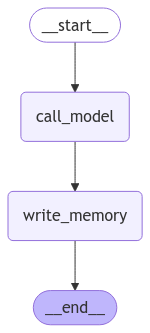

In [19]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history.
This will be saved for long-term memory. If there is an existing memory, simply update it.
Here is the existing memory (it may be empty): {memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [20]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Arshad and I like to play Social Media and learn Agentic AI.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Arshad and I like to play Social Media and learn Agentic AI.
================================== Ai Message ==================================

Hi Arshad!  It's nice to meet you.  I understand you enjoy social media and are interested in learning about agentic AI.  I'll keep that in mind for future conversations.  Is there anything specific you'd like to know or discuss about either topic today?


Let's check the memory in the store.

We can see that the memory is a dictionary that matches our schema.

In [21]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

UserProfile(user_name='Arshad', interests=['Social Media', 'Agentic AI'])

## When can this fail?

[`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) is very useful, but what happens if we're working with a more complex schema?

[Here's](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) an example of a more complex schema, which we'll test below.

This is a [Pydantic](https://docs.pydantic.dev/latest/) model that describes a user's preferences for communication and trust fall.

In [22]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

Now, let's try extraction of this schema using the `with_structured_output` method.

In [25]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

In [24]:
from typing import List, Optional
from pydantic import BaseModel, Field

# Instead of Optional[List[OutputFormat]], directly use List[str] or List[dict]
class TelegramPreferences(BaseModel):
    preferred_encoding: List[str] = []  # Initialize as empty list
    favorite_telegram_operators: List[str] = []
    preferred_telegram_paper: List[str] = []

class MorseCode(BaseModel):
    preferred_key_type: List[str] = []
    favorite_morse_abbreviations: List[str] = []

class Semaphore(BaseModel):
    preferred_flag_color: List[str] = []
    semaphore_skill_level: List[str] = []

class TrustFallPreferences(BaseModel):
    preferred_fall_height: List[str] = []
    trust_level: List[str] = []
    preferred_catching_technique: List[str] = []

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

# Bind schema to model using with_structured_output for simple schema cases and use Trustcall for complex schema cases.

If we naively extract more complex schemas, even using high capacity model like `gpt-4o`, it is prone to failure.


## Trustcall for creating and updating profile schemas

As we can see, working with schemas can be tricky.

Complex schemas can be difficult to extract.

In addition, updating even simple schemas can pose challenges.

Consider our above chatbot.

We regenerated the profile schema *from scratch* each time we chose to save a new memory.

This is inefficient, potentially wasting model tokens if the schema contains a lot of information to re-generate each time.

Worse, we may loose information when regenerating the profile from scratch.

Addressing these problems is the motivation for [TrustCall](https://github.com/hinthornw/trustcall)!

This is an open-source library for updating JSON schemas developed by one [Will Fu-Hinthorn](https://github.com/hinthornw) on the LangChain team.

It's motivated by exactly these challenges while working on memory.

Let's first show simple usage of extraction with TrustCall on this list of [messages](https://python.langchain.com/docs/concepts/messages/).


In [26]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm Arshad."),
                AIMessage(content="Nice to meet you, Arshad."),
                HumanMessage(content="I really like Agentic AI.")]

We use `create_extractor`, passing in the model as well as our schema as a [tool](https://python.langchain.com/docs/concepts/tools/).

With TrustCall, can supply supply the schema in various ways.

For example, we can pass a JSON object / Python dictionary or Pydantic model.

Under the hood, TrustCall uses [tool calling](https://python.langchain.com/docs/concepts/tool_calling/) to produce [structured output](https://python.langchain.com/docs/concepts/structured_outputs/) from an input list of [messages](https://python.langchain.com/docs/concepts/messages/).

To force Trustcall to produce [structured output](https://python.langchain.com/docs/concepts/structured_outputs/), we can include the schema name in the `tool_choice` argument.

We can invoke the extractor with  the above conversation.

In [27]:
from trustcall import create_extractor

# Schema
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

# Initialize model = ChatOpenAI(model="gpt-4o", temperature=0)the model
model = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.5
)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

When we invoke the extractor, we get a few things:

* `messages`: The list of `AIMessages` that contain the tool calls.
* `responses`: The resulting parsed tool calls that match our schema.
* `response_metadata`: Applicable if updating existing tool calls. It says which of the responses correspond to which of the existing objects.


In [28]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (058a1df1-7ef7-4b21-a1d6-6fa4c92fe2a4)
 Call ID: 058a1df1-7ef7-4b21-a1d6-6fa4c92fe2a4
  Args:
    interests: ['Agentic AI']
    user_name: Arshad


In [29]:
schema = result["responses"]
schema

[UserProfile(user_name='Arshad', interests=['Agentic AI'])]

In [30]:
schema[0].model_dump()

{'user_name': 'Arshad', 'interests': ['Agentic AI']}

In [31]:
result["response_metadata"]

[{'id': '058a1df1-7ef7-4b21-a1d6-6fa4c92fe2a4'}]

Let's see how we can use it to *update* the profile.

For updating, TrustCall takes a set of messages as well as the existing schema.

The central idea is that it prompts the model to produce a [JSON Patch](https://jsonpatch.com/) to update only the relevant parts of the schema.

This is less error-prone than naively overwriting the entire schema.

It's also more efficient since the model only needs to generate the parts of the schema that have changed.

We can save the existing schema as a dict.

We can use `model_dump()` to serialize a Pydantic model instance into a dict.

We pass it to the `"existing"` argument along with the schema name, `UserProfile`.

In [32]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Arshad."),
                        AIMessage(content="Nice to meet you, Arshad."),
                        HumanMessage(content="I really like Agentic AI."),
                        AIMessage(content="I understand you  are interested in learning about agentic AI, what else you do?"),
                        HumanMessage(content="I really like to play social media after learning Agentic AI."),]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation},
                                    {"existing": {"UserProfile": schema[0].model_dump()}})

In [33]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (a29d625b-528f-4b5d-9037-08df4e4bdb0b)
 Call ID: a29d625b-528f-4b5d-9037-08df4e4bdb0b
  Args:
    interests: ['Agentic AI', 'Social Media']
    user_name: Arshad


In [34]:
result["response_metadata"]

[{'id': 'a29d625b-528f-4b5d-9037-08df4e4bdb0b'}]

In [35]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Arshad', 'interests': ['Agentic AI', 'Social Media']}

LangSmith trace:

https://smith.langchain.com/public/229eae22-1edb-44c6-93e6-489124a43968/r

Now, let's also test Trustcall on the [challenging schema](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) that we saw earlier.

In [36]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"][0]

TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=['morse'], favorite_telegram_operators=[], preferred_telegram_paper=['Daredevil']), morse_code=MorseCode(preferred_key_type=['straight key'], favorite_morse_abbreviations=[]), semaphore=Semaphore(preferred_flag_color=[], semaphore_skill_level=[])), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=['higher'], trust_level=[], preferred_catching_technique=['diamond formation'])))

Trace:

https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r

For more examples, you can see an overview video [here](https://www.youtube.com/watch?v=-H4s0jQi-QY).

## Chatbot with profile schema updating

Now, let's bring Trustcall into our chatbot to create *and update* a memory profile.

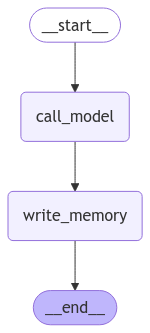

In [38]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.5
)
# Schema
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})

    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [42]:
from typing import List, Optional
from pydantic import BaseModel, Field

# ... (rest of your code) ...

class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="Arshad")
    user_location: str = Field(description="Doha Qatar")
    interests: List[str] = Field(description=["play SocialMedia", "technology", "AI Agents"]) # update this line
                                      # or
                                      # interests: List[dict] = Field(..., description="A list of the user's interests", items={"type":"string"})
                                      # or
                                      # interests: List = Field(..., description="A list of the user's interests", items={"type":"string"})


# ... (rest of your code) ...

In [43]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Arshad")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Arshad


================================== Ai Message ==================================

Hi Arshad!  We've met a couple of times now.  Is there anything I can assist you with?


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[interests].items: missing field.


In [40]:
from typing import List, Optional
from pydantic import BaseModel, Field

# ... (rest of your code) ...

class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: List[str] = Field(description="A list of the user's interests") # update this line
                                      # or
                                      # interests: List[dict] = Field(..., description="A list of the user's interests", items={"type":"string"})
                                      # or
                                      # interests: List = Field(..., description="A list of the user's interests", items={"type":"string"})


# ... (rest of your code) ...

In [44]:
# User input
input_messages = [HumanMessage(content="I like to learning Agentic AI")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to learning Agentic AI


================================== Ai Message ==================================

That's great, Arshad!  Agentic AI is a fascinating and rapidly developing field.  To help me understand how I can best assist you in learning about it, could you tell me a bit more about what aspects of Agentic AI interest you most?  For example, are you interested in the ethical considerations, the technical challenges, specific applications, or something else?


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[interests].items: missing field.


In [45]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

AttributeError: 'NoneType' object has no attribute 'dict'

In [46]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")

# Check if existing_memory is None before calling dict()
if existing_memory is not None:
    print(existing_memory.dict())
else:
    print("Memory not found for user_id:", user_id)

Memory not found for user_id: 1


In [47]:
# The user profile saved as a JSON object
existing_memory.value

AttributeError: 'NoneType' object has no attribute 'value'

In [48]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")

# Check if existing_memory is None before accessing its value
if existing_memory is not None:
    print(existing_memory.value)
else:
    print("Memory not found for user_id:", user_id)

Memory not found for user_id: 1


In [49]:
# User input
input_messages = [HumanMessage(content="I also enjoy playing social media")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy playing social media


================================== Ai Message ==================================

That's interesting, Arshad.  It's good to have a balance between focused learning and leisure activities.  Do you find that using social media helps you relax and unwind after studying Agentic AI, or do you perhaps use it to connect with others who share your interest in the field?


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[interests].items: missing field.


Continue the conversation in a new thread.

In [50]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="What social media  do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What social media  do you recommend for me?


================================== Ai Message ==================================

To recommend the best social media platform for you, I need a little more information about your interests and goals.  What are you hoping to achieve by using social media?  For example, are you looking to:

* **Connect with friends and family?**  If so, platforms like Facebook or Instagram might be good choices.
* **Share your creative work (photography, art, writing, etc.)?**  Instagram, Pinterest, or even TikTok could be suitable.
* **Build a professional network?** LinkedIn is the go-to platform for this.
* **Discover new trends and engage in discussions?** Twitter or TikTok might be more appealing.
* **Watch short-form videos?** TikTok or YouTube Shorts are excellent options.
* **Engage in specific hobbies or interests?**  There are many niche platforms catering to specific communities.

Tell me more about what you're looking for, and I can give you a more tailored recommendation.


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[interests].items: missing field.


Trace:

https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r

## Studio

![Screenshot 2024-10-30 at 11.26.31 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0437060f1754ea79908_Screenshot%202024-11-11%20at%207.48.53%E2%80%AFPM.png)